In [1]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import UnetPlus
from ImageLoader import ImageLoader2D

In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "UnetPlus"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [4]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 100


100it [00:10,  9.56it/s]


In [5]:
# Splitting the data, seed for reproducibility
seed_value = 42
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)
print(f"Using random seed {seed_value}")
print(f"Train Set Size {len(x_train)}")
print(f"Valid Set Size {len(x_valid)}")
print(f"Test Set Size {len(x_test)}")


Using random seed 42
Train Set Size 80
Valid Set Size 10
Test Set Size 10


In [6]:
# Defining the augmentations

aug__horizon_train = albu.Compose([
    albu.HorizontalFlip(),
])

aug__vertical_train = albu.Compose([
    albu.VerticalFlip(),
])

aug__color_train = albu.Compose([
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
])

aug__affine_train = albu.Compose([
    albu.Affine(),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        horizon = aug__horizon_train(image=x_train[i], mask=y_train[i])
        vertical = aug__vertical_train(image=x_train[i], mask=y_train[i])
        color = aug__color_train(image=x_train[i], mask=y_train[i])
        affine = aug__affine_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(horizon['image'])  
        y_train_out.append(horizon['mask'])
        x_train_out.append(vertical['image'])  
        y_train_out.append(vertical['mask'])
        x_train_out.append(color['image'])  
        y_train_out.append(color['mask'])
        x_train_out.append(affine['image'])  
        y_train_out.append(affine['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [7]:
# Creating the model

model = UnetPlus.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [8]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [9]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
80/80 [==============================] - 28s 264ms/step - loss: 0.6467 - val_loss: 0.8058
Loss Validation: 0.8037226
Loss Test: 0.8751475
Saved model with val_loss:  0.8037226


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 1
Learning Rate: 0.0001
80/80 [==============================] - 20s 246ms/step - loss: 0.5577 - val_loss: 0.6623
Loss Validation: 0.6552957
Loss Test: 0.7920137
Saved model with val_loss:  0.6552957


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 2
Learning Rate: 0.0001
80/80 [==============================] - 20s 246ms/step - loss: 0.5015 - val_loss: 0.6668
Loss Validation: 0.6611195
Loss Test: 0.7994778
Training, epoch 3
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.4587 - val_loss: 0.5705
Loss Validation: 0.56503105
Loss Test: 0.7177236
Saved model with val_loss:  0.56503105


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 4
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.4360 - val_loss: 0.4738
Loss Validation: 0.46329904
Loss Test: 0.68507385
Saved model with val_loss:  0.46329904


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 5
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.4044 - val_loss: 0.4163
Loss Validation: 0.3923062
Loss Test: 0.474007
Saved model with val_loss:  0.3923062


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 6
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.3804 - val_loss: 0.4318
Loss Validation: 0.4109817
Loss Test: 0.47212833
Training, epoch 7
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.3459 - val_loss: 0.4031
Loss Validation: 0.38736385
Loss Test: 0.5737849
Saved model with val_loss:  0.38736385


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 8
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.3284 - val_loss: 0.3902
Loss Validation: 0.37009752
Loss Test: 0.45711738
Saved model with val_loss:  0.37009752


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 9
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.3085 - val_loss: 0.3519
Loss Validation: 0.330961
Loss Test: 0.38526332
Saved model with val_loss:  0.330961


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 10
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.2906 - val_loss: 0.3691
Loss Validation: 0.3505538
Loss Test: 0.4254653
Training, epoch 11
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.2692 - val_loss: 0.3469
Loss Validation: 0.3256995
Loss Test: 0.49000406
Saved model with val_loss:  0.3256995


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 12
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.2579 - val_loss: 0.3856
Loss Validation: 0.36343563
Loss Test: 0.48033464
Training, epoch 13
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.2357 - val_loss: 0.3710
Loss Validation: 0.34687716
Loss Test: 0.3824225
Training, epoch 14
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.2353 - val_loss: 0.3439
Loss Validation: 0.32472408
Loss Test: 0.35126233
Saved model with val_loss:  0.32472408


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 15
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.2093 - val_loss: 0.3663
Loss Validation: 0.34759015
Loss Test: 0.3435285
Training, epoch 16
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.2030 - val_loss: 0.3454
Loss Validation: 0.3270086
Loss Test: 0.35053986
Training, epoch 17
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1932 - val_loss: 0.3079
Loss Validation: 0.29212457
Loss Test: 0.3045593
Saved model with val_loss:  0.29212457


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 18
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1753 - val_loss: 0.3063
Loss Validation: 0.29210192
Loss Test: 0.32963336
Saved model with val_loss:  0.29210192


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 19
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1741 - val_loss: 0.3668
Loss Validation: 0.3497513
Loss Test: 0.32217878
Training, epoch 20
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1604 - val_loss: 0.3351
Loss Validation: 0.31637627
Loss Test: 0.37737757
Training, epoch 21
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1611 - val_loss: 0.3335
Loss Validation: 0.3145135
Loss Test: 0.32803762
Training, epoch 22
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1522 - val_loss: 0.3122
Loss Validation: 0.2925195
Loss Test: 0.28185225
Training, epoch 23
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.1355 - val_loss: 0.3315
Loss Validation: 0.3124532
Loss Test: 0.29139495
Training, epoch 24
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 25
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1226 - val_loss: 0.3128
Loss Validation: 0.29457003
Loss Test: 0.27659225
Training, epoch 26
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1124 - val_loss: 0.2893
Loss Validation: 0.27560437
Loss Test: 0.23730576
Saved model with val_loss:  0.27560437


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 27
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1158 - val_loss: 0.2775
Loss Validation: 0.2622407
Loss Test: 0.2537505
Saved model with val_loss:  0.2622407


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 28
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.0997 - val_loss: 0.3324
Loss Validation: 0.31691796
Loss Test: 0.307782
Training, epoch 29
Learning Rate: 0.0001
80/80 [==============================] - 20s 247ms/step - loss: 0.1041 - val_loss: 0.3075
Loss Validation: 0.28610712
Loss Test: 0.38649315
Training, epoch 30
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.1005 - val_loss: 0.3080
Loss Validation: 0.2860425
Loss Test: 0.2608738
Training, epoch 31
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.0893 - val_loss: 0.2990
Loss Validation: 0.28314644
Loss Test: 0.22826481
Training, epoch 32
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - loss: 0.0802 - val_loss: 0.2862
Loss Validation: 0.2664767
Loss Test: 0.40193415
Training, epoch 33
Learning Rate: 0.0001
80/80 [==============================] - 20s 248ms/step - l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 39
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0645 - val_loss: 0.2938
Loss Validation: 0.28026724
Loss Test: 0.27618802
Training, epoch 40
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0680 - val_loss: 0.2576
Loss Validation: 0.245749
Loss Test: 0.21871018
Saved model with val_loss:  0.245749


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 41
Learning Rate: 0.0001
80/80 [==============================] - 17s 210ms/step - loss: 0.0605 - val_loss: 0.2666
Loss Validation: 0.26221675
Loss Test: 0.21480042
Training, epoch 42
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0585 - val_loss: 0.2997
Loss Validation: 0.283719
Loss Test: 0.27642286
Training, epoch 43
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0603 - val_loss: 0.2873
Loss Validation: 0.27278066
Loss Test: 0.23972738
Training, epoch 44
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0613 - val_loss: 0.2875
Loss Validation: 0.27322394
Loss Test: 0.21230888
Training, epoch 45
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0600 - val_loss: 0.2680
Loss Validation: 0.25519633
Loss Test: 0.22503364
Training, epoch 46
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 69
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0391 - val_loss: 0.2798
Loss Validation: 0.26282483
Loss Test: 0.26302058
Training, epoch 70
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0401 - val_loss: 0.2803
Loss Validation: 0.26188326
Loss Test: 0.22772413
Training, epoch 71
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0332 - val_loss: 0.2800
Loss Validation: 0.260629
Loss Test: 0.23963988
Training, epoch 72
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0424 - val_loss: 0.2538
Loss Validation: 0.23766762
Loss Test: 0.2600894
Saved model with val_loss:  0.23766762


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 73
Learning Rate: 0.0001
80/80 [==============================] - 17s 210ms/step - loss: 0.0347 - val_loss: 0.2809
Loss Validation: 0.26124835
Loss Test: 0.20394975
Training, epoch 74
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0347 - val_loss: 0.2811
Loss Validation: 0.26094872
Loss Test: 0.2505018
Training, epoch 75
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0393 - val_loss: 0.2493
Loss Validation: 0.23594427
Loss Test: 0.23968828
Saved model with val_loss:  0.23594427


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 76
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0369 - val_loss: 0.2616
Loss Validation: 0.24308175
Loss Test: 0.2064625
Training, epoch 77
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0353 - val_loss: 0.2777
Loss Validation: 0.2588299
Loss Test: 0.23662812
Training, epoch 78
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0332 - val_loss: 0.2897
Loss Validation: 0.27131742
Loss Test: 0.20135778
Training, epoch 79
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0339 - val_loss: 0.2827
Loss Validation: 0.2629037
Loss Test: 0.25778705
Training, epoch 80
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0374 - val_loss: 0.2503
Loss Validation: 0.23388791
Loss Test: 0.20920074
Saved model with val_loss:  0.23388791


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 81
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0368 - val_loss: 0.2590
Loss Validation: 0.24370432
Loss Test: 0.21651381
Training, epoch 82
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0355 - val_loss: 0.2725
Loss Validation: 0.25335371
Loss Test: 0.24030602
Training, epoch 83
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0331 - val_loss: 0.2992
Loss Validation: 0.28103864
Loss Test: 0.25027138
Training, epoch 84
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0318 - val_loss: 0.2763
Loss Validation: 0.2569725
Loss Test: 0.21696979
Training, epoch 85
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0323 - val_loss: 0.2710
Loss Validation: 0.25566506
Loss Test: 0.24686909
Training, epoch 86
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 152
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0193 - val_loss: 0.2644
Loss Validation: 0.24721432
Loss Test: 0.19261873
Training, epoch 153
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0185 - val_loss: 0.2709
Loss Validation: 0.25318205
Loss Test: 0.21224177
Training, epoch 154
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0189 - val_loss: 0.2826
Loss Validation: 0.26349664
Loss Test: 0.22671378
Training, epoch 155
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0203 - val_loss: 0.2835
Loss Validation: 0.2625295
Loss Test: 0.24093848
Training, epoch 156
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0186 - val_loss: 0.2662
Loss Validation: 0.24622416
Loss Test: 0.21447098
Training, epoch 157
Learning Rate: 0.0001
80/80 [==============================] - 17s 211m

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 205
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0164 - val_loss: 0.2486
Loss Validation: 0.23807257
Loss Test: 0.23705673
Training, epoch 206
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0156 - val_loss: 0.2544
Loss Validation: 0.23868334
Loss Test: 0.19791055
Training, epoch 207
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0138 - val_loss: 0.2594
Loss Validation: 0.2383439
Loss Test: 0.22184283
Training, epoch 208
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0157 - val_loss: 0.2741
Loss Validation: 0.25453162
Loss Test: 0.21204531
Training, epoch 209
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0152 - val_loss: 0.2649
Loss Validation: 0.24325007
Loss Test: 0.20516789
Training, epoch 210
Learning Rate: 0.0001
80/80 [==============================] - 17s 211m

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 237
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0123 - val_loss: 0.2270
Loss Validation: 0.21053618
Loss Test: 0.19029498
Saved model with val_loss:  0.21053618


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37\assets


Training, epoch 238
Learning Rate: 0.0001
80/80 [==============================] - 17s 210ms/step - loss: 0.0122 - val_loss: 0.2603
Loss Validation: 0.23899668
Loss Test: 0.20433223
Training, epoch 239
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0137 - val_loss: 0.2614
Loss Validation: 0.24557972
Loss Test: 0.19080687
Training, epoch 240
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0125 - val_loss: 0.2496
Loss Validation: 0.23568892
Loss Test: 0.22641331
Training, epoch 241
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0125 - val_loss: 0.2572
Loss Validation: 0.23687124
Loss Test: 0.20706081
Training, epoch 242
Learning Rate: 0.0001
80/80 [==============================] - 17s 211ms/step - loss: 0.0130 - val_loss: 0.2752
Loss Validation: 0.25312054
Loss Test: 0.2166946
Training, epoch 243
Learning Rate: 0.0001
80/80 [==============================] - 17s 211m

Loading the model
ModelSaveTensorFlow/UnetPlus_filters_17_2024_4_1_22_44_37
3/3 [==============================] - 0s 56ms/step
results_UnetPlus_17_kvasir.txt


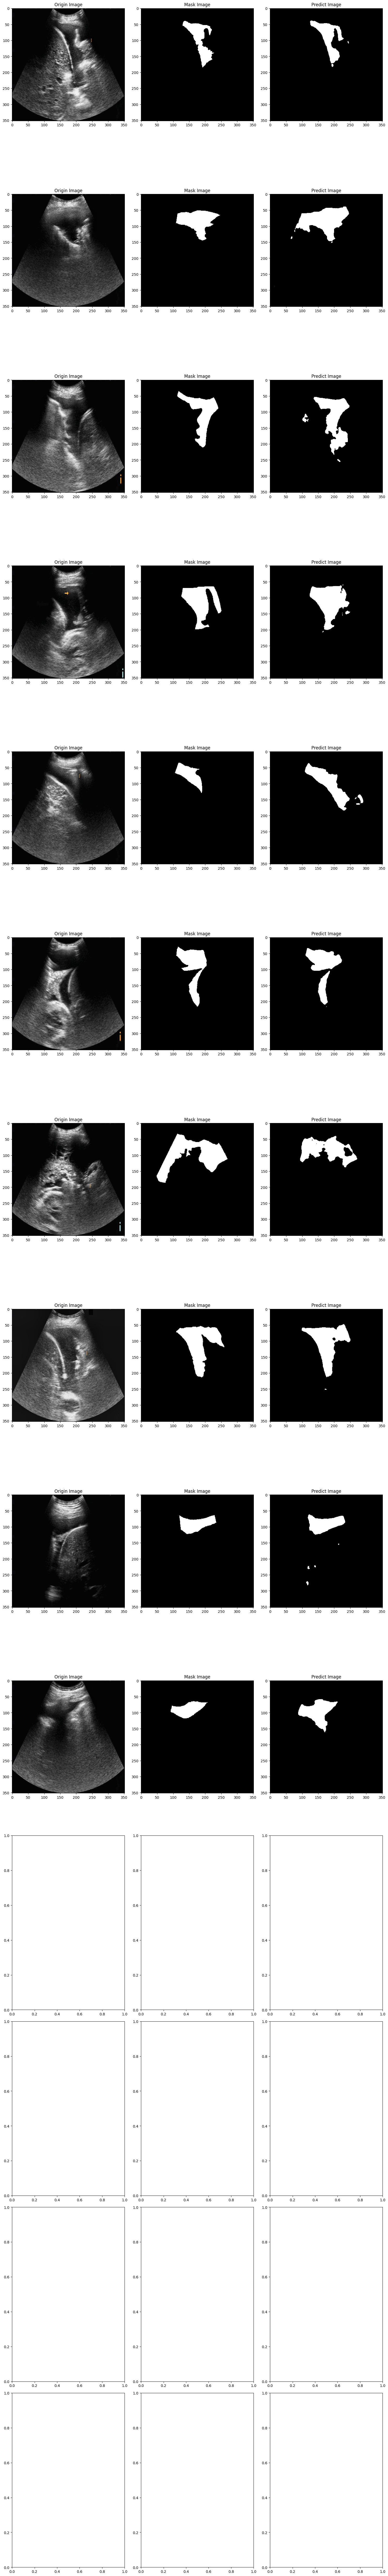

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
File done


In [10]:
# Computing the metrics and saving the results

print("Loading the model")
print(model_path)

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(14, 3, figsize=(15, 100))

final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')
    
     # 計算個別數值
    dice_value = f1_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                         np.ndarray.flatten(prediction_test[i] > 0.5))
    miou_value = jaccard_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                              np.ndarray.flatten(prediction_test[i] > 0.5))
    precision_value = precision_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                      np.ndarray.flatten(prediction_test[i] > 0.5))
    recall_value = recall_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                np.ndarray.flatten(prediction_test[i] > 0.5))
    accuracy_value = accuracy_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                    np.ndarray.flatten(prediction_test[i] > 0.5))

    with open(final_file, 'a') as f:
        f.write(f'Metrics for sample {i + 1}:\n')
        f.write(f'Dice: {dice_value}\n')
        f.write(f'MIOU: {miou_value}\n')
        f.write(f'Precision: {precision_value}\n')
        f.write(f'Recall: {recall_value}\n')
        f.write(f'Accuracy: {accuracy_value}\n')
        f.write('\n')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')